# Prediciendo qué marca se comprará

A continuación usaremos regresión logística para intentar predecir qué marca comprará un **cliente en promedio** y luego analizaremos lo mismo pero considerando a cada segmento.

Primero, vamos a construir un modelo estadístico. Luego calcularemos la elasticidad de la probabilidad de selección promedio de las cinco marcas, luego para cada marca en particular y finalmente para cada segmento.

Tengamos en cuenta que el set de datos con el que trabajamos cuenta con información acerca de qué marca compró un determinado cliente, por lo tanto, usaremos dicha columna (entre otras) para estimar qué marca comprará el cliente medio y luego que marca comprará cada segmento.

La idea detrás de esto es poder aumentar las ganancias, pero también intentar aumentar la satisfacción del cliente.

Como hemos dicho, usaremos un regresor logístico, pero esta vez será un estimador del tipo *multiclase* ya que tenemos varias marcas en las cuales queremos estimar la probabilidad de compra. Este tipo de modelos se llama *regresión logística multinomial* ya que clasificaremos más de dos clases.

In [65]:
### Librerías

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pickle

from sklearn.linear_model import LogisticRegression 

import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()

from utils import elasticidadPropia
from utils import elasticidadCruzada, getPricesDF

## Preparando datos

Al igual que antes, vamos a preprar los datos. Es decir, vamos a procesar de tal manera de obtener los segmentos utilizando los modelos (standardScaler, PCA, KMeans) que hemos entrenado.

In [66]:
#Cargamos los datos crudos
df_compras = pd.read_csv("datasets/purchase_data.csv")
# df_compras.head()
# print(df_compras.columns)

# Cargamos el modelo de escalamiento o scaler que entrenamos anteriormente.
scaler = pickle.load(open('models/scaler.pickle', 'rb'))

#  Cargamos el modelo de PCA
pca = pickle.load(open('models/pca.pickle', 'rb'))

# Cargamos el modelo PCA
kmeans_pca = pickle.load(open('models/kmeans_pca.pickle', 'rb'))

## Aplicamos estandarización

features = df_compras[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_compras_std = scaler.transform(features)

# Aplicamos PCA a los datos estandarizados
df_compras_pca = pca.transform(df_compras_std)

# Segmentamos los datos usando el modelo de KMeans entrenado previamente
segmentos = kmeans_pca.predict(df_compras_pca)

# Creamos una copia del dataframe original para trabajar sin modificar los datos del set original.
df_compras_predictor = df_compras.copy()

# Agregamos labels
df_compras_predictor["Segmento"] = segmentos

Necesitamos sólo las compras efectivas, es decir, donde la columna *Incidence* es igual a 1.

In [67]:
df_comprados = df_compras_predictor[df_compras_predictor["Incidence"] == 1]
df_comprados.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segmento
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,0,0,0,0,47,1,110866,1,0,2
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,0,1,0,0,47,1,110866,1,0,2
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,1,0,0,0,47,1,110866,1,0,2
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,0,0,0,0,47,1,110866,1,0,2
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,1,1,0,0,47,1,110866,1,0,2


Dado que queremos predecir **qué marca** se comprará, vamos a utilizar la columna *Brand* como variable dependiente. De momento usaremos la columna de precios como variable independiente.

In [68]:
Y = df_comprados["Brand"]

features = ['Price_1', 'Price_2', 'Price_3', 'Price_4','Price_5']
X = df_comprados[features]

Notar que ahora tomamos las 5 columnas de precios de manara separada y no como un promedio.

### Modelo de regresión de múltiple selección

Entrenamos el modelo de regresión logística para predecir la compra de las marcas de barras de chocolate.

In [69]:
lr_marca_predictor = LogisticRegression(solver = "sag", multi_class = "multinomial", max_iter = 300)
lr_marca_predictor.fit(X,Y)

LogisticRegression(max_iter=300, multi_class='multinomial', solver='sag')

**NOTA**

Si bien hemos entrenado un clasificador que se entrena utilizando features que contiene información de múltiples clases -en nuestro caso son 5 clases correspondiente a 5 marcas diferentes-, el modelo nos clasificará *una clase por cada instancia observada*. Es decir, que ante una observación de 5 precios -correspondientes a los precios de cada marca- el clasificador nos dirá a qué sólo una marca que se comprará considerando los datos observados.

Los coeficientes obtenidos luego de entrenar el algoritmo se encuentran dentro de un array de $5\times5$. Esto esta bien, ya que tenemos cinco marcas y cinco features y el algoritmo intentará predecir, para una marca vs las otras cuatro, la probabilidad de que una observación pertenezca a la clase (marca en cuestión). Es decir, tenemos una marca o *clase* positiva, versus cuatro clases negativas. Por lo tanto, para la marca 1 tenemos 5 coeficientes, para la marca 2, otros cinco, etc.

Intenemos analizar qué nos están indicando estos coeficientes.

In [70]:
bc_coef = pd.DataFrame(lr_marca_predictor.coef_.T)
coeficientes = ["CM1","CM2","CM3","CM4","CM5"] #CM = Coeficiente Marca
bc_coef.columns = [coeficientes]
precios = ["P1","P2","P3","P4","P5"] #P = Precio
bc_coef.index = [precios]
bc_coef = bc_coef.round(2)
bc_coef

,CM1,CM2,CM3,CM4,CM5
P1,-3.92,1.27,1.62,0.57,0.44
P2,0.66,-1.88,0.56,0.40,0.26
P3,2.42,-0.21,0.50,-1.40,-1.31
P4,0.70,-0.21,1.04,-1.25,-0.29
P5,-0.20,0.59,0.45,0.25,-1.09


*Nota*: al hacer la traspuesta de la matriz de coeficientes lo que obtenemos son las *features* como filas.

Recordemos que, **cuanto más alto el precio de una marca respecto de sí misma, menos probable es que sea comprada**, por lo cual tiene sentido que el coeficiente CM1 respecto de P1 sea negativo. Por otro lado, cuanto más se incrementen los precios de las marcas competidoras, más alta debería ser la probabilidad de que los clientes compren, por ejemplo, la marca 1 (aplica para las otras marcas también). Por lo tanto, es posible encontrar valores positivos en algunos rengoles donde comparamos el precio de una marca versus las otras cuatro. Por ejemplo, para la columna CM1 vemos valores positivos para P2, P3 y P4.

No obstante, debemos tener bien en claro que la probabilidades de selección de alguna marca en base a alguna observación están interrelacionadas, por eso, debemos analizar los números de manera global y no de manera particular. Estos efectos se deben a lom que se conoce como *efectos de la propia marca* y *efectos cruzados*. Es decir, que los cambios en una marca, afectan su propia probabilidad de ser elegida, pero también la de las otras marcas.

#### Resumen de precios para cada marca

In [71]:
df_comprados[['Price_1', 'Price_2', 'Price_3', 'Price_4','Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000
mean,1.384559,1.764717,2.006694,2.159658,2.654296
std,0.090944,0.181667,0.046200,0.093253,0.097724
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.570000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.180000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


## Elasticidad propia - Marca 5

Vamos a analizar la elasticidad de precios para la marca 5. Primero para clientes promedio y luego por segmento.

Estamos interesados en estudiar la elasticidad sobre la marca 5 ante cambios de precio de la propia marca y también que pasa con la probabilida de compra sobre la marca 5 cuando las marcas de la competencia cambian sus precios, esto es *elasticidad cruzada*.

Vamos a generar un nuevo dataframe para guardar datos sólo de la marca 5. Ya que queremos calcular la elasticidad para la marca 5 (*own elasticity*) lo que haremos es colocar en las columnas de precio 1 hasta precio 4 los precios medios de dichas marcas, y en la columna de precio 5 colocaremos los valores que hemos creado dentro de la variable *rango_precios*.

In [72]:
rango_precios = pd.DataFrame(np.arange(0.5, 3.5, 0.01), columns = ["precio"]).round(2)

In [73]:
df_own_m5 = pd.DataFrame(index = np.arange(rango_precios.size)) #own_m5: elasticidad propia (marca 5)
df_own_m5 = pd.DataFrame(index = np.arange(rango_precios.size))
df_own_m5["Price_1"] = df_comprados["Price_1"].mean()
df_own_m5["Price_2"] = df_comprados["Price_2"].mean()
df_own_m5["Price_3"] = df_comprados["Price_3"].mean()
df_own_m5["Price_4"] = df_comprados["Price_4"].mean()
df_own_m5["Price_5"] = rango_precios
# df_own_m5.head()

Escencialmente lo que vamos a hacer es **projectar las probabilidades de compra de la marca 5 para diferentes precios**.

Para esto, utilizaremos el modelo de regresión lineal que hemos entrenado previamente llamado *lr_marca_predictor*. Vamos a utilizar los datos dentro del dataframe *df_own_m5* ya que contiene las variaciones de precio para la marca 5.

In [74]:
#Elasaticidades totales para la probabilidad de compra para la marca cinco (own)
probas_completas_m5_own = lr_marca_predictor.predict_proba(df_own_m5)

Sólo estamos interesados en la columna 5 de la variable *probas_completas_m5_own* dado que es esta la que contiene los valores de elasticidad para la marca 5.

In [75]:
probas_m5_own = probas_completas_m5_own[:,4]

A continuación usaremos la fórmula de Elasticidad de Precios para ver cómo evoluciona la probabilidad de compra de la marca 5 ante cambios de precios.

$$ E = \beta_{m5} \times precio \times \left(1- P(compra)\right) $$

Donde $\beta_{m5}$ corresponde al coeficiente del precio de la marca 5 (fila 5) respecto de las variables dependientes de la marca cinco, es decir, la última columna.

In [76]:
beta_m5 = bc_coef.iloc[4,4]
beta_m5

-1.09

Calculamos la elasticidad

In [77]:
pe_m5_own = beta_m5*rango_precios["precio"]*(1-probas_m5_own)
pe_m5_own = elasticidadPropia(probas_m5_own,beta_m5, rango_precios["precio"])
# pe_m5_own

Creamos un dataframe *maestro* que contendrá los valores de todas las elasticidades que iremos calculando.

In [78]:
master_elasticidades = pd.DataFrame(rango_precios["precio"].values, columns = ["precio"]) #dataframe con los valores de elasticidad
master_elasticidades["pe_m5_own"] = pe_m5_own

#### Graficando la elasticidad para la marca 5

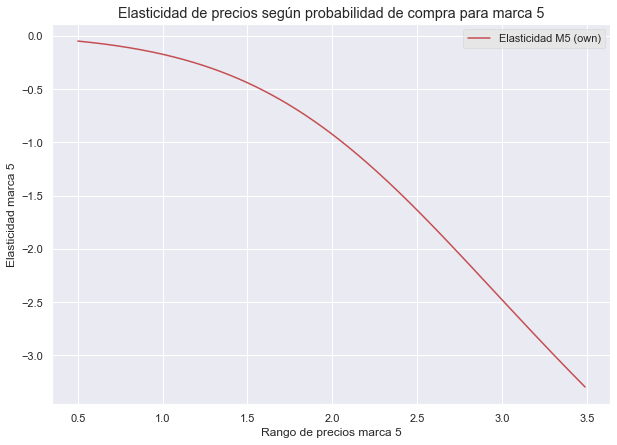

In [79]:
## Graficamos
fif, ax = plt.subplots(figsize = (10,7))
plt.style.use("ggplot")
ax.set_title("Elasticidad de precios según probabilidad de compra para marca 5")
ax.set_xlabel("Rango de precios marca 5")
ax.set_ylabel("Elasticidad marca 5")
ax.plot(master_elasticidades["precio"], master_elasticidades["pe_m5_own"], color = "r", label = "Elasticidad M5 (own)")

plt.legend()
plt.show()


Como comentario inicial, la elasticidad de la marca 5 (propia) posee un coeficiente negativo, lo cual nos dice que para aumentos de precio, la probabilidad de compra decaerá, lo cual tiene perfecto sentido, ya que suponemos que aumentos de precio, generan menos compradores.

Sería interesante comparar cómo se comportará la probabilidad de compra de la marca 5 ante cambios en las marcas competidoras.

### Elasticidad cruzada marca 5 con variaciones de precio en marca 4

En escencia vamos a realizar los mismos pasos que para calcular la elasticidad de la marca cinco consigomisma, pero esta vez vamos a usar el rango de precios en la columna correspondiente a la marca 4 dentro del dataframe que usaremos para estimar las probabilidades.

Veamos

In [80]:
df_m5_cross_m4 = pd.DataFrame(index = np.arange(rango_precios.size)) #own_m5: elasticidad propia (marca 5)
df_m5_cross_m4 = pd.DataFrame(index = np.arange(rango_precios.size))
df_m5_cross_m4["Price_1"] = df_comprados["Price_1"].mean()
df_m5_cross_m4["Price_2"] = df_comprados["Price_2"].mean()
df_m5_cross_m4["Price_3"] = df_comprados["Price_3"].mean()
df_m5_cross_m4["Price_4"] = rango_precios
df_m5_cross_m4["Price_5"] = df_comprados["Price_5"].mean()

Ahora usaremos el modelo de regresión logística que hemos entrenado.

In [81]:
probas_completas_m5_cross_m4 = lr_marca_predictor.predict_proba(df_m5_cross_m4)

#### Importante

Para calcular la elasticidad cruzada vamos a usar una fórmula diferente a la que hemos usado antes. La ecuación para calcular elasticidad cruzada es la siguiente,

$$ E_{cruzada} = -\beta_{precio~marca~propia} \times precio(marca~cruzada) \times P(marca~cruzada)$$

Donde,

- $P(marca cruzada)$: Es la probabilidad de selección de la marca 4 ante los cambios de precios.
- $Precio(marca cruzada)$: Es el precio de la marca cruzada, en este caso también la marca 4. 

In [82]:
#nos quedamos con las probabilidedes correspondientes a la marca 4
prob_compra_m4 = probas_completas_m5_cross_m4[:,3]
pe_m5_cross_m4 = elasticidadCruzada(prob_compra_m4,beta_m5,rango_precios["precio"])
# pe_m5_cross_m4

In [83]:
master_elasticidades["pe_m5_cross_m4"] = pe_m5_cross_m4
# master_elasticidades.head()

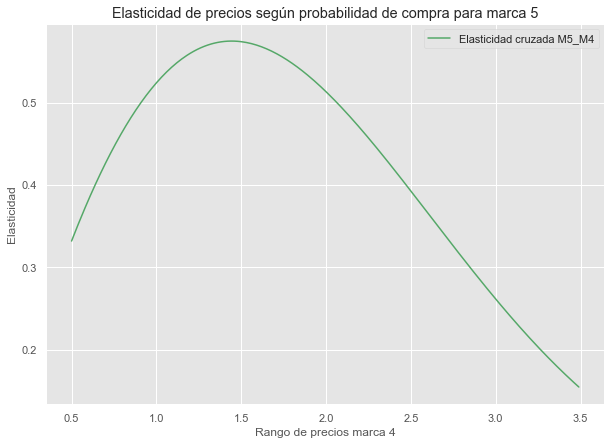

In [84]:
## Graficamos
fif, ax = plt.subplots(figsize = (10,7))
plt.style.use("ggplot")
ax.set_title("Elasticidad de precios según probabilidad de compra para marca 5")
ax.set_xlabel("Rango de precios marca 4")
ax.set_ylabel("Elasticidad")
ax.plot(master_elasticidades["precio"], master_elasticidades["pe_m5_cross_m4"], color = "g", label = "Elasticidad cruzada M5_M4")

plt.legend()
plt.show()

Podemos ver que a medida que el precio de la marca 4 aumenta, la probabilidad de compra de la marca 5 aumenta. Esto no debería sorprendernos.

Si volvemos a analizar los valores medios de precios para las diferentes marcas podremos notar que la marca 4 está en el rango de 1,76USD y el de 2.26USD. Considerando la gráfica de elasticidad cruzada de la marca 5 respecto de la marca 4, podremos notar que la elasticidad decrece lentamente, no obastante, sigue siendo positiva, indicando que la probabilidad de compra de la marca 5 sigue creciendo con el incremento de precio en la marca 4 pero a una velocidad menor.

Entonces, podríamos pensar en generar estrategias de venta de la marca 5 para intentar captar clientes que compran la marca 4, ya que, como podemos ver, la marca 4 en el rango de precios que actualmente maneja, estaría dentro del rango de *sustituto débil*.

Ahora bien, los valores de elasticidad cruzada pueden darnos ideas de cómo se encuentra el mercado de barras de chocolate para el público que estamos analizando.

- Si el valor de la elasticidad cruzada es mayor a cero, se considera que los dos productos son *sustitutos* entre si.
$$ E(marca~cruzada)  >0 ~ sustitutas$$

Esto tiene sentido ya que los productos que estamos comparando son barras de chocolate. Ahora bien, podríamos estar comparando barras de chocolate con vino y en ese caso, la elasticidad cruzada no necesariamente nos daría valores positivos.

- Si el valor absoluto de la elasticidad cruzada, supera en algún punto al valor absoluto de la elasticidad de la propia marca bajo estudio, entonces se considera que la marca alternativa es una **fuerte candidata** a sustituir a la marca bajo análisis.

$$ |E(marca~cruzada)| > |E(marca~bajo~estudio)| ~ Marca alternativa fuerte sustituta $$

*¿Podemos decir que la marca 4 es una candidata a sustituir la marca 5?* Eso dependerá del precio que estemos evaluando.

Grafiquemos los valores absolutos de las elasticidades de la marca 5 y la elasticidad cruzada m5 y m4.

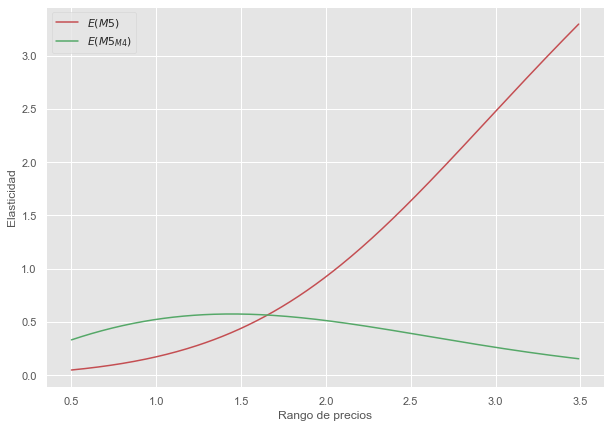

In [85]:
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title = ("Elasticidad de precios")
ax.set_xlabel("Rango de precios")
ax.set_ylabel("Elasticidad")
ax.plot(master_elasticidades["precio"], np.abs(master_elasticidades["pe_m5_own"].values), color = "r", label = "$E(M5)$")
ax.plot(master_elasticidades["precio"], np.abs(master_elasticidades["pe_m5_cross_m4"].values), color = "g", label = "$E(M5_{M4})$")
plt.legend()
plt.show()

Podemos decir que la marca 4 es una posible sustituta de la marca 5 para todo el rango de precios desde 0.5 hasta poco más de 1.5 (según se ve en el gráfico anterior).

De algo estamos seguros, ninguna marca hará feliz a todos los clientes, no obstante, podríamos intentar lograr que una marca intente hacer feliz a un segmento en particular.

A continuación, vamos a mejorar el modelo para observar la elasticidad pero por segmentos de clientes.

### Análisis de elasticidad propia y elasticidad cruzada para la marca 5 evaluada por segmentos

Estamos interesados en analizar la probabilidad de compra o selección de la marca 5 por cada uno de los segmentos.

Analizaremos primero el segmento *acomodados*. Sabemos que es el que mayormente compra la marca 4 (ver la notebook *analizandoCompras*).

Primeramente filtramos los datos sólo para el segmento 3. Recordemos que sólo nos intera las veces que sí se realizo una compra, es decir, donde *Incidence* es iguala a uno.

In [86]:
df_comprdos_s3 = df_compras_predictor[(df_compras_predictor["Incidence"]==1)&(df_compras_predictor["Segmento"]==3)] #compras realizadas solo para segmento 3
# df_comprdos_s3 #3391 filas x25 columnas

### Segmento 3

Para analizar la elasticidad de precios del segmento tres vamos a proceder de la misma forma que venimos haciendo, pero usaremos *df_comprdos_s3*.

Debemos entrenar un modelo usando los datos para el segmento tres.

In [87]:
lr_marca_predictor_s3 = LogisticRegression(solver = "sag", multi_class = "multinomial", max_iter = 300) #modelo predictor para segmento 3

In [88]:
Y = df_comprdos_s3["Brand"]
# Y.value_counts()
X = df_comprdos_s3[features]

#entrenamos modelo
lr_marca_predictor_s3.fit(X,Y)

#creamos dataframe con los coeficientes
coef_modelo_s3 = pd.DataFrame(np.transpose(lr_marca_predictor_s3.coef_))
coef_modelo_s3.columns = [coeficientes]
coef_modelo_s3.index = [precios]
coef_modelo_s3 = coef_modelo_s3.round(2)
# coef_modelo_s3

#### Elasticidad propia (marca 5) para segmento 3 (acomodados)

In [89]:
df_own_m5_s3 = pd.DataFrame(index = np.arange(rango_precios.size)) #data frame cálculo de probabilidad de compra para marca 5 (own)
df_own_m5_s3["Price_1"] = df_comprdos_s3["Price_1"].mean()
df_own_m5_s3["Price_2"] = df_comprdos_s3["Price_2"].mean()
df_own_m5_s3["Price_3"] = df_comprdos_s3["Price_3"].mean()
df_own_m5_s3["Price_4"] = df_comprdos_s3["Price_4"].mean()
df_own_m5_s3["Price_5"] = rango_precios

Utilizamos el modelo entrenado para prdecir las probabilidades y así calcular la elasticidad.

Debemos notar que usamos el beta del primer modelo.

**NOTA:** Debo investigar por qué se utiliza para el cálculo de elasticidades el coeficiente beta5 del primer modelo y no del nuevo modelo entrenado sobre el sub espacio de datos.

In [90]:
probas_completas_m5_own_s3 = lr_marca_predictor_s3.predict_proba(df_own_m5_s3)
probas_m5_own_s3 = probas_completas_m5_own_s3[:,4]
# beta_m5_s3 = coef_modelo_s3.iloc[4,4]

pe_m5_own_s3 = elasticidadPropia(probas_m5_own_s3,beta_m5,rango_precios["precio"])
master_elasticidades["pe_m5_own_s3"] = pe_m5_own_s3

#### Elasticidad cruzada (marca 5 con 4) para segmento 3 (acomodados)

In [91]:
df_m5_cross_m4_s3 = pd.DataFrame(index = np.arange(rango_precios.size)) #data frame cálculo de probabilidad de compra para marca 5 (own)
df_m5_cross_m4_s3["Price_1"] = df_comprdos_s3["Price_1"].mean()
df_m5_cross_m4_s3["Price_2"] = df_comprdos_s3["Price_2"].mean()
df_m5_cross_m4_s3["Price_3"] = df_comprdos_s3["Price_3"].mean()
df_m5_cross_m4_s3["Price_4"] = rango_precios
df_m5_cross_m4_s3["Price_5"] = df_comprdos_s3["Price_5"].mean()

probas_completas_m5_cross_m4_s3 = lr_marca_predictor_s3.predict_proba(df_m5_cross_m4_s3) #calculamos probabilidades
prob_compra_m4_s3 = probas_completas_m5_cross_m4_s3[:,3] #probabilida de compra de marca 4 para el segmento 3
pe_m5_cross_m4_s3 =  elasticidadCruzada(prob_compra_m4_s3, beta_m5, rango_precios["precio"]) #elasticidad cruzada marca 5 con 4
master_elasticidades["pe_m5_cross_m4_s3"] = pe_m5_cross_m4_s3
# master_elasticidades

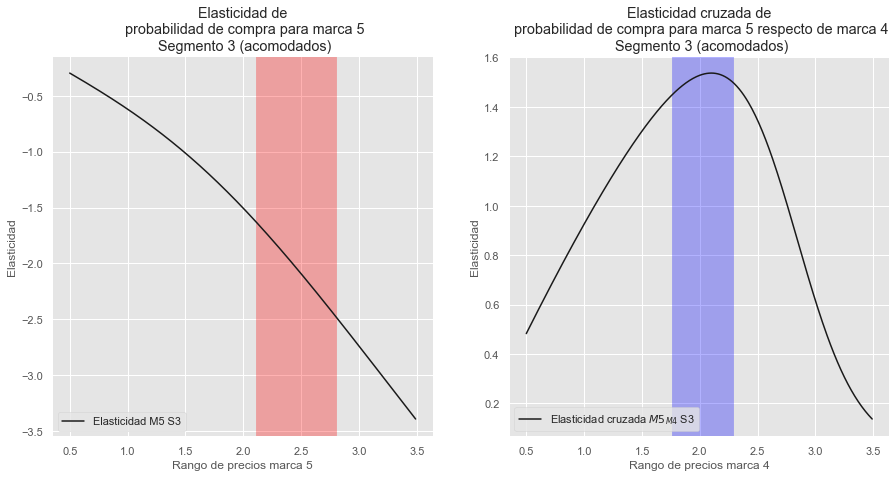

In [92]:
fif, ax = plt.subplots(1,2, figsize = (15,7))
plt.style.use("ggplot")

ax[0].set_title("Elasticidad de\n probabilidad de compra para marca 5\n Segmento 3 (acomodados)")
ax[0].set_xlabel("Rango de precios marca 5")
ax[0].set_ylabel("Elasticidad")
ax[0].plot(master_elasticidades["precio"], master_elasticidades["pe_m5_own_s3"], color = "k", label = "Elasticidad M5 S3")
ax[0].axvspan(2.11, 2.8, color='red', alpha=0.3)
ax[0].legend()

ax[1].set_title("Elasticidad cruzada de\n probabilidad de compra para marca 5 respecto de marca 4\n Segmento 3 (acomodados)")
ax[1].set_xlabel("Rango de precios marca 4")
ax[1].set_ylabel("Elasticidad")
ax[1].plot(master_elasticidades["precio"], master_elasticidades["pe_m5_cross_m4_s3"], color = "k", label = "Elasticidad cruzada $M5_{M4}$ S3")
ax[1].axvspan(1.76, 2.29, color='blue', alpha=0.3)
ax[1].legend()

plt.show()

NOTA: Debemos tener en cuenta que los precios en los ejes x de los gráficos representan los cambios en los precios para la marca 5 y marca 4, respectivamente.

Recordemos que,

- Rango de precios marca 5: entre 2.11USD y 2.8USD
- Rango de precios marca 4: entre 1.76USD y 2.29USD

Estos rangos están marcados en los gráficos anteriores.

**Elasticidad marca 5 consigo misma - Segmento 3**

Según la gráfica de la izquierda, en el rango de precios de la marca 5, el segmento de *acomodados* es elástico respecto a si misma (own brand). Esto es esperable, ya que como vimos, este segmento se inclina mayoritariamente por la marca 4, por lo tanto, aumentos de precios en la marca 5 haría que la probabilidad de selección de la marca 5 sea aún menor.

**Elasticidad cruzada de marca 5 respecto de la marca 4 - Segmento 3**

Podemos ver que la elasticidad cruzada para el segmento 3 son todos valores positivos, por ende, la marca 4 podría ser una sustituta de la marca 5 en el rango de precios que figura en la base de datos.

### Cambios de precios en la marca competidora

¿Qué pasaría si la competencia decrementa el precio de las barras de chocolate de marca 4 en $1\%$?

Podemos determinar si la probabilidad, de que el segmento de *acomodados* compre o no la marca 5, aumentará o disminuirá con este decremento de precio.

Veamos esto con un ejemplo, supongamos un precio para la marca 4 es 2USD. Necesitamos saber qué valor tiene la columna *pe_m5_cross_m4_s3* referente a los valores de elasticidad cruzada de la marca 5 respecto de la marca 4.

In [93]:
master_elasticidades.loc[149:151]

,precio,pe_m5_own,pe_m5_cross_m4,pe_m5_own_s3,pe_m5_cross_m4_s3
149,1.99,-0.912524,0.515344,-1.494668,1.525929
150,2.00,-0.924586,0.513361,-1.505509,1.527730
151,2.01,-0.936743,0.511354,-1.516388,1.529375


Podemos ver que para un precio de 2USD, la elasticidad cruzada *pe_m5_cross_m4_s3* es de $1.52$. Por lo tanto, si el precio de la marca 4 cae en $1\%$, la probabilidad de que el segmento de personas *acomodadas* compre la marca 5 **¡decaerá en 1.5%!**.

¿Qué hacemos entonces? Podríamos también decrementar el precio de nuestro producto en $1\%$. ¿Cómo impactaría esto en la probabilidad de compra del segmento 3 en la marca 5?

Supongamos tomamos un precio dentro del rango de precios en el cual está definida la marca 5, digamos $2.4$USD.

In [94]:
master_elasticidades.loc[189:191]

,precio,pe_m5_own,pe_m5_cross_m4,pe_m5_own_s3,pe_m5_cross_m4_s3
189,2.39,-1.463606,0.421704,-1.955970,1.440502
190,2.40,-1.478977,0.419100,-1.968155,1.433267
191,2.41,-1.494412,0.416490,-1.980368,1.425745


Para el caso en que el precio de la marca 5 es de $2.4$USD el valor de elasticidad de la marca 5, segmento 3 dada por la columna *pe_m5_own_s3* es de aproximadamente $-1.97$. Por lo tanto, si decrementamos en $1\%$ el precio de la marca 5, esperariamos obtener un **incremento** de casi $2\%$ en la probabilidad de compra de la marca 5 por parte del segmento de acomodados.

Es decir, obtenemos un efecto neto de alrededor de **$0.5\%$** de **incrementar** las probabilidades de compra de la marca 5 si ante un decremento de $1\%$ la marca 4, nosotros decrementamos $1\%$ el precio de la marca 5.

#### Manteniendo la misma cantidad de clientes

En teoría, podemos usar los datos dados por las elasticidades tanto propias como las cruzadas para no perder clientes.

Si el precio de la competencia (marca 4) es de $2$USD sabemos que su elasticidad es de $1.5\%$. Por lo tanto, podemos plantear la siguiente ecuación,

$$ 2\times x = 1.5\% $$

Donde $x$ representa el valor porcentual de decremento que debemos realizar sobre la marca 5 si quisieramos mantener la probabilidad de compra de la marca 5 en valores iguales al que teníamos previamente al decremento de precios de la marca 4.

Siguiendo con el ejemplo anterior, $x = 0.75%$, es decir, que deberíamos decrementar el precio de la marca 5 en %0.75\%% para *teóricamente* mantener la misma probabilidad de compra por parte del segmento 3.

### Elasticidad cruzada de la marca 5 respecto de la marca 4 para los segmentos 0, 1 y 2

In [95]:
#creamos los dataframe
df_comprados_s0 = df_comprados[df_comprados["Segmento"] == 0] #segmento estandar
df_comprados_s1 = df_comprados[df_comprados["Segmento"] == 1] #segmento enfocado en trabajar
df_comprados_s2 = df_comprados[df_comprados["Segmento"] == 2] #segmento de baja oportunidad

#creamos los modelos y los entrenamos
lr_marca_predictor_s0 = LogisticRegression(solver = "sag", multi_class = "multinomial", max_iter = 300)
lr_marca_predictor_s1 = LogisticRegression(solver = "sag", multi_class = "multinomial", max_iter = 300)
lr_marca_predictor_s2 = LogisticRegression(solver = "sag", multi_class = "multinomial", max_iter = 300)

Y = df_comprados_s0["Brand"]
X = df_comprados_s0[features]
lr_marca_predictor_s0.fit(X,Y)

Y = df_comprados_s1["Brand"]
X = df_comprados_s1[features]
lr_marca_predictor_s1.fit(X,Y)

Y = df_comprados_s2["Brand"]
X = df_comprados_s2[features]
lr_marca_predictor_s2.fit(X,Y)

LogisticRegression(max_iter=300, multi_class='multinomial', solver='sag')

#### Elasticidad para marca 5 (own) para cada segmento

In [96]:
# dataframes con los precios que usaremos para predecir las probabilidades de compra

# segmento 0
medias = []
for feature in features:
    medias.append(df_comprados_s0[feature].mean())

df_own_m5_s0 = getPricesDF(rango_precios,medias,features,"Price_5")

# segmento 1
medias = []
for feature in features:
    medias.append(df_comprados_s1[feature].mean())

df_own_m5_s1 = getPricesDF(rango_precios,medias,features,"Price_5")

# segmento 2
medias = []
for feature in features:
    medias.append(df_comprados_s2[feature].mean())

df_own_m5_s2 = getPricesDF(rango_precios,medias,features,"Price_5")

Calculamos las probabiliades de compra

In [97]:
## Calculamos las probabilidades de compra de la marca 5 para los segmenos 0, 1 y 2

prob_compra_m5_s0 = lr_marca_predictor_s0.predict_proba(df_own_m5_s0)[:,4]
prob_compra_m5_s1 = lr_marca_predictor_s1.predict_proba(df_own_m5_s1)[:,4]
prob_compra_m5_s2 = lr_marca_predictor_s2.predict_proba(df_own_m5_s2)[:,4]

Calculamos las elasticidades

In [98]:
pe_m5_own_s0 =  elasticidadPropia(prob_compra_m5_s0,beta_m5,rango_precios["precio"])
pe_m5_own_s1 =  elasticidadPropia(prob_compra_m5_s1,beta_m5,rango_precios["precio"])
pe_m5_own_s2 =  elasticidadPropia(prob_compra_m5_s2,beta_m5,rango_precios["precio"])

Actualizamos el dataframe que contiene los valores de elasticidades

In [99]:
master_elasticidades["pe_m5_own_s0"] = pe_m5_own_s0
master_elasticidades["pe_m5_own_s1"] = pe_m5_own_s1
master_elasticidades["pe_m5_own_s2"] = pe_m5_own_s2
# master_elasticidades.head()

#### Elasticidades cruzadas para marca 5 respecto de marca 4 para cada segmento

In [100]:
# dataframes con los precios que usaremos para predecir las probabilidades de compra

# segmento 0
medias = []
for feature in features:
    medias.append(df_comprados_s0[feature].mean())

df_m5_cross_m4_s0 = getPricesDF(rango_precios,medias,features,"Price_4")

# segmento 1
medias = []
for feature in features:
    medias.append(df_comprados_s1[feature].mean())

df_m5_cross_m4_s1 = getPricesDF(rango_precios,medias,features,"Price_4")

# segmento 2
medias = []
for feature in features:
    medias.append(df_comprados_s2[feature].mean())

df_m5_cross_m4_s2 = getPricesDF(rango_precios,medias,features,"Price_4")

In [101]:
## Calculamos las probabilidades de compra de la marca 4 para los segmenos 0, 1 y 2

prob_compra_m4_s0 = lr_marca_predictor_s0.predict_proba(df_m5_cross_m4_s0)[:,3]
prob_compra_m4_s1 = lr_marca_predictor_s1.predict_proba(df_m5_cross_m4_s1)[:,3]
prob_compra_m4_s2 = lr_marca_predictor_s2.predict_proba(df_m5_cross_m4_s2)[:,3]

In [102]:
## Calculamos las elasticidades
pe_m5_cross_m4_s0 = elasticidadCruzada(prob_compra_m4_s0, beta_m5, rango_precios["precio"])
pe_m5_cross_m4_s1 = elasticidadCruzada(prob_compra_m4_s1, beta_m5, rango_precios["precio"])
pe_m5_cross_m4_s2 = elasticidadCruzada(prob_compra_m4_s2, beta_m5, rango_precios["precio"])

Actualizamos el dataframe que contiene los valores de elasticidades

In [103]:
master_elasticidades["pe_m5_cross_m4_s0"] = pe_m5_cross_m4_s0
master_elasticidades["pe_m5_cross_m4_s1"] = pe_m5_cross_m4_s1
master_elasticidades["pe_m5_cross_m4_s2"] = pe_m5_cross_m4_s2
master_elasticidades.head()

,precio,pe_m5_own,pe_m5_cross_m4,pe_m5_own_s3,pe_m5_cross_m4_s3,pe_m5_own_s0,pe_m5_own_s1,pe_m5_own_s2,pe_m5_cross_m4_s0,pe_m5_cross_m4_s1,pe_m5_cross_m4_s2
0,0.50,-0.049055,0.332011,-0.297315,0.482421,-0.115835,-0.043940,-0.001036,0.174112,0.194769,0.181593
1,0.51,-0.050616,0.337287,-0.303361,0.491726,-0.118874,-0.045027,-0.001098,0.176167,0.197253,0.183890
2,0.52,-0.052207,0.342507,-0.309417,0.501015,-0.121948,-0.046123,-0.001163,0.178172,0.199686,0.186138
3,0.53,-0.053827,0.347668,-0.315484,0.510289,-0.125057,-0.047229,-0.001231,0.180125,0.202068,0.188337
4,0.54,-0.055477,0.352773,-0.321562,0.519548,-0.128202,-0.048344,-0.001303,0.182029,0.204400,0.190488


### Graficamos los datos obtenidos

A continuación graficaremos los valores de elasticidad de la marca 5 (own) para cada segmento y también los valores de elasticidad cruzada de la marca 5 respecto la marca 4 para cada segmento.

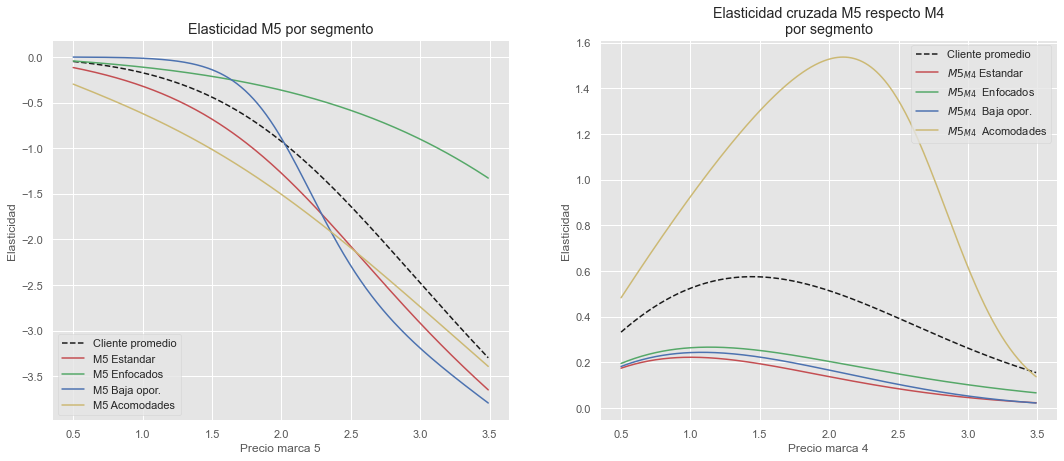

In [104]:
fig, ax = plt.subplots(1,2, figsize = (18,7))

ax[0].set_title("Elasticidad M5 por segmento")
ax[0].set_xlabel("Precio marca 5")
ax[0].set_ylabel("Elasticidad")
ax[0].plot(master_elasticidades["precio"], master_elasticidades["pe_m5_own"], label = "Cliente promedio", color = "k", linestyle = "--")
ax[0].plot(master_elasticidades["precio"], master_elasticidades["pe_m5_own_s0"], label = "M5 Estandar", color = "r")
ax[0].plot(master_elasticidades["precio"], master_elasticidades["pe_m5_own_s1"], label = "M5 Enfocados", color = "g")
ax[0].plot(master_elasticidades["precio"], master_elasticidades["pe_m5_own_s2"], label = "M5 Baja opor.", color = "b")
ax[0].plot(master_elasticidades["precio"], master_elasticidades["pe_m5_own_s3"], label = "M5 Acomodades", color = "y")
ax[0].legend()

ax[1].set_title("Elasticidad cruzada M5 respecto M4\npor segmento")
ax[1].set_xlabel("Precio marca 4")
ax[1].set_ylabel("Elasticidad")
ax[1].plot(master_elasticidades["precio"], master_elasticidades["pe_m5_cross_m4"], label = "Cliente promedio", color = "k", linestyle = "--")
ax[1].plot(master_elasticidades["precio"], master_elasticidades["pe_m5_cross_m4_s0"], label = "$M5_{M4}$ Estandar", color = "r")
ax[1].plot(master_elasticidades["precio"], master_elasticidades["pe_m5_cross_m4_s1"], label = "$M5_{M4}$  Enfocados", color = "g")
ax[1].plot(master_elasticidades["precio"], master_elasticidades["pe_m5_cross_m4_s2"], label = "$M5_{M4}$  Baja opor.", color = "b")
ax[1].plot(master_elasticidades["precio"], master_elasticidades["pe_m5_cross_m4_s3"], label = "$M5_{M4}$  Acomodades", color = "y")
ax[1].legend()

plt.show()